In [0]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras
import warnings
warnings.filterwarnings('ignore')

In [0]:
!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

--2020-04-26 22:16:33--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip’

fma_metadata.zip    100%[===================>] 341.81M  25.1MB/s    in 14s     

2020-04-26 22:16:48 (24.4 MB/s) - ‘fma_metadata.zip’ saved [358412441/358412441]



In [0]:
!wget https://os.unil.cloud.switch.ch/fma/fma_small.zip

--2020-04-26 22:17:07--  https://os.unil.cloud.switch.ch/fma/fma_small.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7679594875 (7.2G) [application/zip]
Saving to: ‘fma_small.zip’

fma_small.zip       100%[===================>]   7.15G  26.4MB/s    in 4m 41s  

2020-04-26 22:21:49 (26.0 MB/s) - ‘fma_small.zip’ saved [7679594875/7679594875]



In [0]:
!cp "/content/drive/My Drive/Music Classification/fma_metadata.zip" "fma_metadata.zip"
!cp "/content/drive/My Drive/Music Classification/fma_small.zip" "fma_small.zip"


In [0]:
!unzip fma_metadata.zip
!unzip fma_small.zip

Streaming output truncated to the last 5000 lines.
 bunzipping: fma_small/068/068601.mp3  
 bunzipping: fma_small/068/068680.mp3  
 bunzipping: fma_small/068/068682.mp3  
 bunzipping: fma_small/068/068683.mp3  
 bunzipping: fma_small/068/068820.mp3  
 bunzipping: fma_small/068/068821.mp3  
 bunzipping: fma_small/068/068837.mp3  
 bunzipping: fma_small/068/068838.mp3  
 bunzipping: fma_small/068/068839.mp3  
 bunzipping: fma_small/068/068840.mp3  
 bunzipping: fma_small/068/068841.mp3  
 bunzipping: fma_small/068/068842.mp3  
 bunzipping: fma_small/068/068843.mp3  
 bunzipping: fma_small/068/068844.mp3  
 bunzipping: fma_small/068/068851.mp3  
 bunzipping: fma_small/068/068852.mp3  
 bunzipping: fma_small/068/068853.mp3  
 bunzipping: fma_small/068/068854.mp3  
 bunzipping: fma_small/068/068860.mp3  
 bunzipping: fma_small/068/068861.mp3  
 bunzipping: fma_small/068/068862.mp3  
 bunzipping: fma_small/068/068869.mp3  
 bunzipping: fma_small/068/068872.mp3  
 bunzipping: fma_small/068/06

In [0]:
# Directory where mp3 are stored.
filepath = '/content/fma_metadata/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
tracks.head()

album                       ... track                 
         comments         date_created  ...  tags            title
track_id                                ...                       
2               0  2008-11-26 01:44:45  ...    []             Food
3               0  2008-11-26 01:44:45  ...    []     Electric Ave
5               0  2008-11-26 01:44:45  ...    []       This World
10              0  2008-11-26 01:45:08  ...    []          Freeway
20              0  2008-11-26 01:45:05  ...    []  Spiritual Level

[5 rows x 52 columns]

In [0]:
keep_cols = [('set', 'split'),
('set', 'subset'),('track', 'genre_top'), ('track', 'genres')]

df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']
df_all.head()

set            track       
             split subset genre_top genres
track_id                                  
2         training  small   Hip-Hop   [21]
5         training  small   Hip-Hop   [21]
10        training  small       Pop   [10]
140       training  small      Folk   [17]
141       training  small      Folk   [17]

In [0]:
df_all.shape

(8000, 4)

In [0]:
df_all[('track', 'genre_top')].value_counts()

Experimental     1000
Pop              1000
Electronic       1000
International    1000
Folk             1000
Instrumental     1000
Hip-Hop          1000
Rock             1000
Name: (track, genre_top), dtype: int64

In [0]:
df_all[('set', 'split')].value_counts()

training      6400
validation     800
test           800
Name: (set, split), dtype: int64

In [0]:
def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [0]:
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
keep_cols = [('set', 'split'),
('set', 'subset'),('track', 'genre_top')]

df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']

df_all[('track_id', 'track_id')] = df_all.index
('track_id', 'track_id')
df_all.head()
df_all.to_csv('/content/df_all.csv')


set            track track_id
             split subset genre_top track_id
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [0]:
## tain-validation-test folders
import os
import numpy as np
import os, shutil

base_dir = '/content/modeldata'
try:
  os.mkdir(base_dir)
except:
  pass

def getGenres():
  return ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


folders = [
  {'name': 'train'},
  {'name': 'test'},
  {'name': 'validation'}
]
for f in folders:
  directory = os.path.join(base_dir, f["name"])
  try:
    os.mkdir(directory)
  except OSError as exc:
    if exc.errno != errno.EEXIST:
      raise
    pass
  genres = getGenres()
  for g in genres:
    genre_directory = os.path.join(directory, g)
    try:
      os.mkdir(genre_directory)
    except:
      pass

 

In [0]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

AUDIO_DIR = '/content/fma_small'

# mel-spectrogram parameters
SR = 12000
N_FFT = 512
N_MELS = 96
HOP_LEN = 256


def create_spectogram(track_id, genre):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    spect = librosa.feature.melspectrogram(y=y, sr=SR,n_fft=N_FFT,hop_length=HOP_LEN,n_mels=N_MELS)
    spect = librosa.power_to_db(spect, ref=np.max)
    librosa.display.specshow(spect, sr=SR, hop_length=HOP_LEN, 
                         x_axis='time', y_axis='mel')    
    plt.colorbar(format='%+2.0f dB');
    plt.title(str(genre))
    
    

In [0]:
filepath = '/content/df_all.csv'
wanted = pd.read_csv(filepath, index_col=0, header=[0, 1])
wanted.head()

set            track track_id
             split subset genre_top track_id
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [0]:
  count = 1

  for index, row in wanted.iterrows():
    track_id = int(row[('track_id','track_id')])
    genre = row[('track', 'genre_top')]
    split = row[('set', 'split')]
    create_spectogram(track_id, genre)
    plt.savefig(f'/content/modeldata/{split}/{genre}/{track_id}.jpg');

    print(count)    
    count = count + 1
 


 

NameError: ignored

In [2]:
from PIL import Image
jpgfile = Image.open("/content/drive/My Drive/Music Classification/spectogram/test/Electronic/108524.jpg")
print(jpgfile.bits, jpgfile.size, jpgfile.format)


8 (432, 288) JPEG


In [6]:
  from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()                                     
test_datagen = ImageDataGenerator()
                                

# this is a generator that will read pictures found in
# subfolers of our train, validation data 
train_generator = train_datagen.flow_from_directory(
        directory='/content/drive/My Drive/Music Classification/spectogram/training',  # this is the target directory
        target_size=(96, 1366),  
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='categorical',
        )

validation_generator = validation_datagen.flow_from_directory(
        directory='/content/drive/My Drive/Music Classification/spectogram/validation',  # this is the target directory
        target_size=(96, 1366),  
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='categorical',
        )

test_generator = test_datagen.flow_from_directory(
        directory='/content/drive/My Drive/Music Classification/spectogram/test',  # this is the target directory
        target_size=(96, 1366),  
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode=None,
        )

Found 6397 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [2]:
train_generator.class_indices
validation_generator.class_indices
test_generator.class_indices


{'Electronic': 0,
 'Experimental': 1,
 'Folk': 2,
 'Hip-Hop': 3,
 'Instrumental': 4,
 'International': 5,
 'Pop': 6,
 'Rock': 7}

In [0]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(56,kernel_size=(5,5),activation ='relu',kernel_regularizer= regularizers.l1_l2(l1=1e-5, l2=1e-4),name='convolution1',input_shape=(96, 1366,1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(56,kernel_size=(5,5),activation ='relu',kernel_regularizer= regularizers.l1_l2(l1=1e-5, l2=1e-4),name='convolution2'))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(56,kernel_size=(5,5),activation ='relu',kernel_regularizer= regularizers.l1_l2(l1=1e-5, l2=1e-4),name='convolution3'))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(8,activation='softmax'))






In [3]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers

model = models.Sequential()

#kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
#model.add(layers.BatchNormalization(name='bn_0_freq',input_shape=(96, 1366, 1)))
   # Conv block 1
model.add(layers.Conv2D(32,kernel_size=(3, 3),activation='relu', border_mode='same', name='conv1',input_shape=(96, 1366, 3),kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization(name='bn1'))
model.add(layers.ELU())
model.add(layers.MaxPooling2D(pool_size=(2, 4), name='pool1'))
   # Conv block 2
model.add(layers.Conv2D(256,kernel_size=(3, 3),activation='relu', border_mode='same', name='conv2',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization(name='bn2'))
model.add(layers.ELU())
model.add(layers.MaxPooling2D(pool_size=(2, 4), name='pool2'))
   # Conv block 3
model.add(layers.Conv2D(256,kernel_size=(3, 3),activation='relu', border_mode='same', name='conv3',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization(name='bn3'))
model.add(layers.ELU())
model.add(layers.MaxPooling2D(pool_size=(2, 4), name='pool3'))
   # Conv block 4
model.add(layers.Conv2D(192,kernel_size=(3, 3),activation='relu', border_mode='same', name='conv4',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization(name='bn4'))
model.add(layers.ELU())
model.add(layers.MaxPooling2D(pool_size=(3, 4), name='pool4'))
  # Conv block 5
model.add(layers.Conv2D(256,kernel_size=(3, 3),activation='relu', border_mode='same', name='conv5',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization(name='bn5'))
model.add(layers.ELU())
model.add(layers.MaxPooling2D(pool_size=(4, 4), name='pool5'))

model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu', name='pre-output1'))
#model.add(layers.Dense(32, activation='relu', name='pre-output2'))
model.add(layers.Dense(8, activation='softmax', name='output'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_size=(3, 3), activation="relu", name="conv1", input_shape=(96, 1366,..., kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(3, 3), activation="relu", name="conv2", kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(3, 3), activation="relu", name="conv3", kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, kernel_size=(3, 3), activation="relu", name="conv4", kernel_regularizer=<keras.reg..., padding="same")`
/usr/lo

In [0]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
#opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(
            loss='categorical_crossentropy', #kullback_leibler_divergence #categorical_crossentropy
            optimizer=opt,
            metrics=['acc'])


In [0]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss',mode='min')]

In [10]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch= train_generator.labels.size//batch_size,
                epochs=20,
                validation_data=validation_generator,
                validation_steps= validation_generator.labels.size//batch_size,
                #callbacks= my_callbacks,
                shuffle= True
                )



Epoch 1/20
199/199 [==============================] - 56s 282ms/step - loss: 132.7775 - acc: 0.7554 - val_loss: 18.6261 - val_acc: 0.8900
Epoch 2/20
199/199 [==============================] - 54s 272ms/step - loss: 9.6578 - acc: 0.9654 - val_loss: 4.4611 - val_acc: 1.0000
Epoch 3/20
199/199 [==============================] - 54s 272ms/step - loss: 5.0580 - acc: 0.9783 - val_loss: 2.3568 - val_acc: 1.0000
Epoch 4/20
199/199 [==============================] - 54s 272ms/step - loss: 1.9755 - acc: 0.9851 - val_loss: 2.0082 - val_acc: 1.0000
Epoch 5/20
199/199 [==============================] - 54s 272ms/step - loss: 2.0480 - acc: 0.9857 - val_loss: 0.9762 - val_acc: 1.0000
Epoch 6/20
199/199 [==============================] - 54s 272ms/step - loss: 2.1039 - acc: 0.9854 - val_loss: 2.1231 - val_acc: 0.9987
Epoch 7/20
199/199 [==============================] - 54s 272ms/step - loss: 1.9093 - acc: 0.9865 - val_loss: 0.9550 - val_acc: 1.0000
Epoch 8/20
199/199 [==============================] 

In [11]:
model.predict_generator(test_generator,800 // batch_size)


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 17 could not be retrieved. It could be 

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.2091350e-16, 1.4009596e-24, 1.0000000e+00, ..., 1.7890674e-32,
        6.0174805e-18, 2.3242150e-14]], dtype=float32)

In [12]:
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: ignored

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

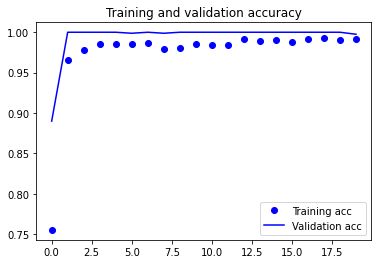

In [16]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

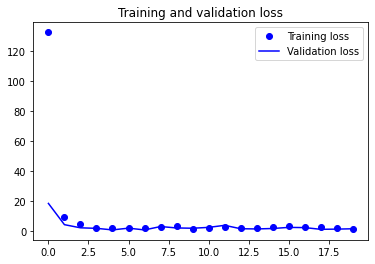

In [17]:
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(test_generator, 800 // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[14 13 10 10  9 14 16 14]
 [13 17 12 10 12 12 14 10]
 [12 12 16 12  8 11 11 18]
 [17 16  9  8 10 13 14 13]
 [ 6 11 13 23 20  9 10  8]
 [11 10 14 12 16 15 12 10]
 [ 9 11  9 17 13 12 10 19]
 [18 10 17  8 12 14 13  8]]
Classification Report
               precision    recall  f1-score   support

   Electronic       0.14      0.14      0.14       100
 Experimental       0.17      0.17      0.17       100
         Folk       0.16      0.16      0.16       100
      Hip-Hop       0.08      0.08      0.08       100
 Instrumental       0.20      0.20      0.20       100
International       0.15      0.15      0.15       100
          Pop       0.10      0.10      0.10       100
         Rock       0.08      0.08      0.08       100

     accuracy                           0.14       800
    macro avg       0.14      0.14      0.14       800
 weighted avg       0.14      0.14      0.14       800



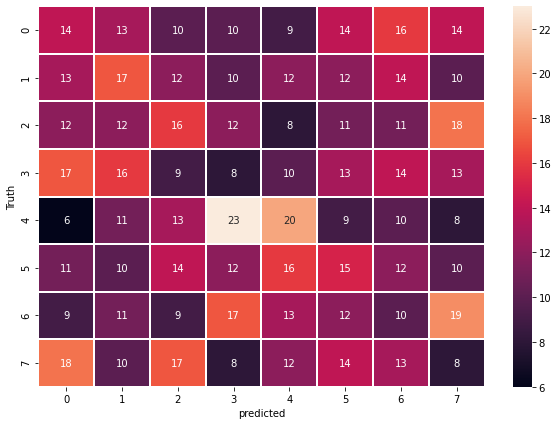

In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn  as  sns

# Plot non-normalized confusion matrix

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(test_generator.classes, y_pred),annot=True,linewidths=1, fmt = 'd')
plt.xlabel('predicted')
plt.ylabel('Truth')
plt.show()